In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import os
from tqdm import tqdm
from pathlib import Path

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
from natsort import natsorted

import alphaMusic.utils.fls_utils as fls
import alphaMusic.utils.acu_utils as acu
import alphaMusic.utils.geo_utils as geo
import alphaMusic.utils.mat_utils as mat

import alphaMusic.evaluation as evl

from alphaMusic.dataloaders import LibriSpeechDataset

import seaborn as sns

import soundfile as sf
import matplotlib.pyplot as plt

from IPython.display import Audio

In [3]:
path_to_librispeech = Path('..','data','LibriSpeech','dev-clean')
path_to_recipe = Path('..','recipes','EUSIPCO22')
print(path_to_librispeech.exists())
print(path_to_recipe.exists())

True
True


In [109]:
db = LibriSpeechDataset('Librispeech', path_to_librispeech, 16000, [6,8], path_to_recipe)

n_samples = 30

room_dim = [6, 5, 3]
RT60_range = [.256]
SNR_range = [10]
DRR_range = [1.5]

# array_setup = acu.echo_array_setup
array_setup = acu.get_echo_array(7, 0.05)
array_center = np.c_[[3.2, 2, 1.2]]

n_srcs = 2
# path_to_noise = Path('..','data','cafet_noise.wav')
path_to_noise = None

dataset_name = 'noRT_noSNR_3src'

path_to_output_pkl = path_to_recipe / Path(f'data/{dataset_name}_data.pkl')

dataset = db.built_dataset(
    n_samples,
    room_dim, RT60_range, SNR_range, DRR_range, 
    array_setup, array_center, 
    n_srcs, path_to_noise, do_plot=False, 
    path_to_pkl=path_to_output_pkl)
dataset = db.load_dataset(path_to_output_pkl)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:25<00:00,  1.18it/s]


done
Saving

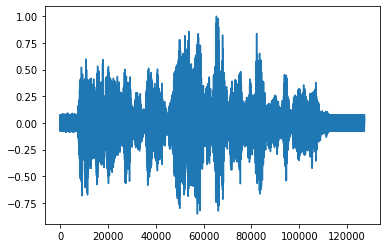

[72.51796927962377, 102.51796927962377]
{'RT60': 0.256, 'SNR': 10.0, 'DRR': -1.157197680290445, 'DER': 3.946236983655788}


In [110]:
(x, doas, acu_params) = dataset[0]
x = x / np.max(np.abs(x),axis=1, keepdims=True)

sf.write('mix.wav', x.T, samplerate=16000)

plt.plot(x[0])
plt.show()
print(doas)
print(acu_params)
Audio(data=x, rate=16000)

In [112]:
import librosa 
from alphaMusic.alphaMUSIC import AlphaMUSIC
import pyroomacoustics as pra
    


algos = ['myMUSIC', 'aMUSIC', 'MUSIC', 'NormMUSIC', 'SRP']

results = []

for n, (x, doas, acu_params) in enumerate(tqdm(dataset)):

    n_mics = x.shape[0]

    # to STFT
    for m in range(n_mics):
        t = len(x[m, :])
        tmp = librosa.core.stft(np.asfortranarray(x[m, :]), n_fft=1024, hop_length=int(1024/4))
        if m == 0:
            obs_FTM = np.zeros([tmp.shape[0], tmp.shape[1], n_mics], dtype=complex)
        obs_FTM[..., m] = tmp
        
    az_res = 1
    az = np.deg2rad(np.linspace(0, 180, 180, endpoint=False))
    # el = np.deg2rad(np.linspace(0, 180., 180, endpoint=False))
    
    seed = 666
    minF = 1000
    maxF = 4000
    
    nfft = 1024
    fs = 16000
    ac_model = 'far'
    mic_pos = array_setup.mic_pos
    
    
    hparams = {
        'seed' : seed,
        'minF' : minF,
        'maxF' : maxF,
        'nfft' : nfft,
        'az_res' : az_res,
    }
    
    # OUR MUSIC
    for algo in algos:
        doa = None
        
        if algo == 'myMUSIC':
            doa = AlphaMUSIC(mic_pos, fs, nfft, c=343, num_src=n_srcs,
                             azimuth=az, mode='far', alpha=2, P_prime=30, 
                             xp=np)
            doa.locate_sources(obs_FTM, freq_range=[minF, maxF])
    
        elif algo == 'aMUSIC':
            doa = AlphaMUSIC(mic_pos, fs, nfft, c=343, num_src=n_srcs,
                     azimuth=az, mode='far', alpha=1.5, P_prime=30, 
                     xp=np)
            doa.locate_sources(obs_FTM, freq_range=[minF, maxF])
    
        else:
            doa = pra.doa.algorithms[algo](mic_pos, fs, nfft, c=343, mode='far', azimuth=az, num_src=n_srcs)
            doa.locate_sources(obs_FTM.transpose([2,0,1]), freq_range=[minF, maxF])
            
        est_doas = np.rad2deg(doa.azimuth_recon)
        
        res_dict = {
            'id' : n,
            'algo' : algo,
            'nsrcs' : n_srcs,
            'doas_est' : est_doas.tolist(),
            'doas_ref' : doas,
            'acu_params' : acu_params,
            'hparams' : hparams,
        }
        results.append(res_dict)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.95it/s]


In [113]:
fls.save_to_pkl(path_to_recipe / Path(f'{dataset_name}_results.pkl'), results)

In [114]:
df = pd.DataFrame()

for r, res_dict in enumerate(results):
    
    # compute metrics
    doas_est = res_dict['doas_est']
    doas_ref = res_dict['doas_ref']
    
    metrics = evl.compute_ssl_metrics(doas_est, doas_ref)
    
    df.at[r,'algo'] = res_dict['algo']
    print([int(d) for d in doas_ref],res_dict['algo'], [int(d) for d in doas_est])
    
    # params
    df.at[r,'nsrcs'] =  res_dict['nsrcs']
    df.at[r,'SNR'] = res_dict['acu_params']['SNR']
    df.at[r,'RT60'] = res_dict['acu_params']['RT60']
    df.at[r,'DRR'] =  res_dict['acu_params']['DRR']
    
    
    # metrics
    df.at[r,'MAE'] = metrics['MAE']
    df.at[r,'RMSE'] = metrics['RMSE']
    df.at[r,'ACC5'] = metrics['ACC5']
    df.at[r,'ACC10'] = metrics['ACC10']
    df.at[r,'MISS'] = metrics['MISS']
    
#     df.at[r,'est'] = np.array(doas_est)
#     df.at[r,'ref'] = np.array(doas_ref)

[72, 102] myMUSIC [93]
[72, 102] aMUSIC [93]
[72, 102] MUSIC [93]
[72, 102] NormMUSIC [80]
[72, 102] SRP [84]
[104, 134] myMUSIC [25, 108]
[104, 134] aMUSIC [24, 110]
[104, 134] MUSIC [25, 108]
[104, 134] NormMUSIC [21, 113]
[104, 134] SRP [116]
[36, 66] myMUSIC [167, 64]
[36, 66] aMUSIC [171, 56]
[36, 66] MUSIC [167, 64]
[36, 66] NormMUSIC [167, 56]
[36, 66] SRP [54]
[133, 163] myMUSIC [160, 148]
[133, 163] aMUSIC [13, 148]
[133, 163] MUSIC [160, 148]
[133, 163] NormMUSIC [12, 148]
[133, 163] SRP [11, 151]
[93, 123] myMUSIC [119, 112]
[93, 123] aMUSIC [26, 114]
[93, 123] MUSIC [119, 112]
[93, 123] NormMUSIC [22, 98]
[93, 123] SRP [105]
[123, 153] myMUSIC [4, 131]
[123, 153] aMUSIC [4, 132]
[123, 153] MUSIC [4, 131]
[123, 153] NormMUSIC [12, 127]
[123, 153] SRP [23, 134]
[76, 106] myMUSIC [100]
[76, 106] aMUSIC [101]
[76, 106] MUSIC [100]
[76, 106] NormMUSIC [170, 104]
[76, 106] SRP [102]
[133, 163] myMUSIC [19, 136]
[133, 163] aMUSIC [9, 136]
[133, 163] MUSIC [19, 136]
[133, 163] Norm

In [115]:
df

,algo,nsrcs,SNR,RT60,DRR,MAE,RMSE,ACC5,ACC10,MISS
0,myMUSIC,2.0,10.0,0.256,-1.157198,9.517969,9.517969,0.0,100.0,50.0
1,aMUSIC,2.0,10.0,0.256,-1.157198,9.517969,9.517969,0.0,100.0,50.0
2,MUSIC,2.0,10.0,0.256,-1.157198,9.517969,9.517969,0.0,100.0,50.0
3,NormMUSIC,2.0,10.0,0.256,-1.157198,7.482031,7.482031,0.0,100.0,50.0
4,SRP,2.0,10.0,0.256,-1.157198,11.482031,11.482031,0.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...
145,myMUSIC,2.0,10.0,0.256,-1.333841,43.500000,53.040258,0.0,0.0,0.0
146,aMUSIC,2.0,10.0,0.256,-1.333841,11.000000,11.653728,0.0,50.0,0.0
147,MUSIC,2.0,10.0,0.256,-1.333841,43.500000,53.040258,0.0,0.0,0.0
148,NormMUSIC,2.0,10.0,0.256,-1.333841,35.500000,47.359958,50.0,50.0,0.0


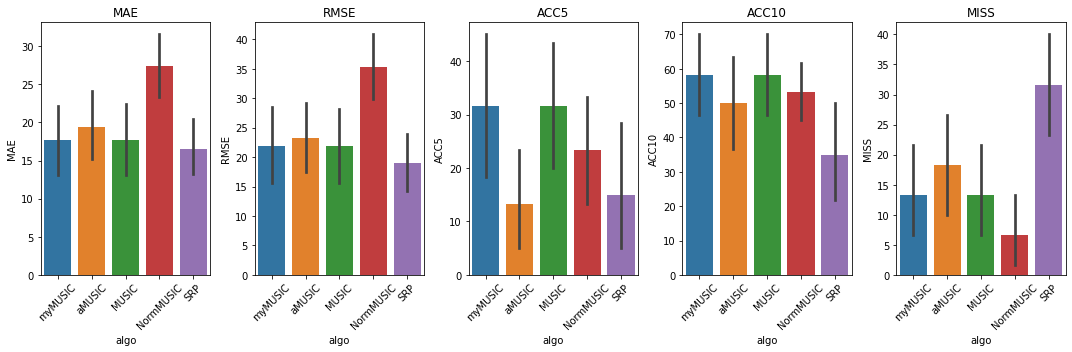

In [116]:
plt.figure(figsize=(15,5))
plt.subplot(151)
plt.title('MAE')
sns.barplot(x='algo', y='MAE', data=df)
plt.xticks(rotation=45)
plt.subplot(152)
plt.title('RMSE')
sns.barplot(x='algo', y='RMSE', data=df)
plt.xticks(rotation=45)
plt.subplot(153)
plt.title('ACC5')
sns.barplot(x='algo', y='ACC5', data=df)
plt.xticks(rotation=45)
plt.subplot(154)
plt.title('ACC10')
sns.barplot(x='algo', y='ACC10', data=df)
plt.xticks(rotation=45)
plt.subplot(155)
plt.title('MISS')
sns.barplot(x='algo', y='MISS', data=df)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()